In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import datetime
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## 线性回归

### 准备数据

In [3]:
n = 400 # 样本数量
X = 10 * torch.rand((n, 2)) - 5.0 # (n, 2)
w0 = torch.tensor([[2.0], [-3.0]]) # (2, 1)
b0 = torch.tensor([[10.0]]) # (1, 1)
Y = torch.mm(X, w0) + b0 + torch.normal(0.0, 2.0, size=(n, 1)) # Y (n, 1)

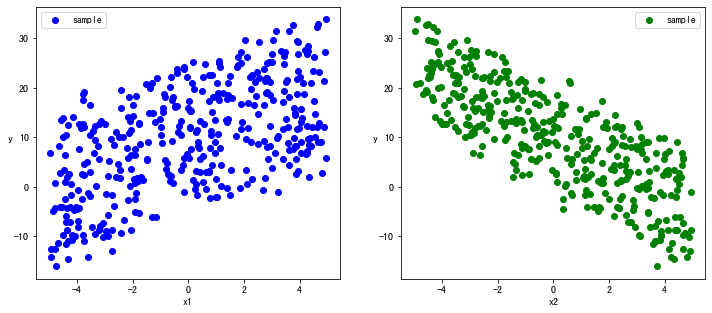

In [4]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='sample')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='sample')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

In [5]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        # index_select 第一个参数 选取的维度 0: 行, 1: 列
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

batch_size = 8
features, labels = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[-4.6042,  0.0822],
        [-1.1850, -1.6990],
        [ 3.4091,  4.6460],
        [-0.4015, -3.2574],
        [-1.6432,  0.8176],
        [ 3.6128, -0.3648],
        [-2.4317, -4.5704],
        [ 0.9930,  2.6242]])
tensor([[ 2.7792],
        [13.0920],
        [ 5.6942],
        [16.2705],
        [ 1.4281],
        [18.0751],
        [19.5770],
        [ 1.6016]])


### 定义模型

In [6]:
class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.zeros_like(b0, requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b
    
    def loss_func(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2 / 2)
    
model = LinearRegression()

### 训练模型

In [7]:
def train_step(model, features, labels):
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    
    # 反向传播
    loss.backward()
    
    with torch.no_grad():
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad
        
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [8]:
batch_size = 10
features, labels = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

tensor(61.4753, grad_fn=<MeanBackward0>)

In [9]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)
        if epoch % 200 == 0:
            printbar()
            print('epoch = {}, loss = {}'.format(epoch, loss.item()))
            print('model.w = {}'.format(model.w.data))
            print('model.b = {}'.format(model.b.data))
            
train_model(model, epochs=1000)


================================================================================2021-06-18 15:28:01
epoch = 200, loss = 1.410837173461914
model.w = tensor([[ 2.0073],
        [-2.9880]])
model.b = tensor([[9.8703]])

================================================================================2021-06-18 15:28:03
epoch = 400, loss = 1.6210968494415283
model.w = tensor([[ 2.0094],
        [-2.9879]])
model.b = tensor([[9.8739]])

================================================================================2021-06-18 15:28:04
epoch = 600, loss = 2.0676960945129395
model.w = tensor([[ 2.0068],
        [-2.9877]])
model.b = tensor([[9.8737]])

================================================================================2021-06-18 15:28:06
epoch = 800, loss = 1.409938097000122
model.w = tensor([[ 2.0069],
        [-2.9883]])
model.b = tensor([[9.8736]])

================================================================================2021-06-18 15:28:07
epoch = 1000, loss = 0.876369

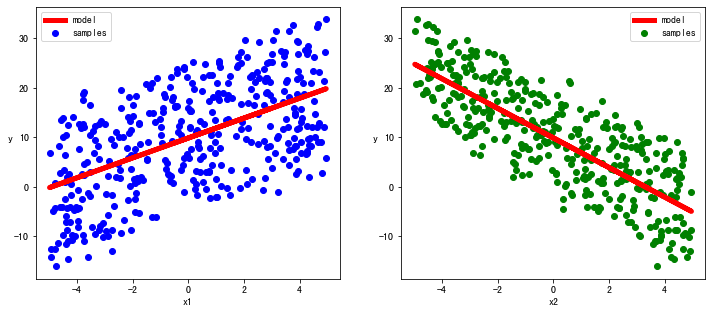

In [10]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='samples')
ax1.plot(X[:, 0].numpy(), (model.w[0].data * X[:, 0] + model.b[0].data).numpy(),
         '-r',
         linewidth=5.0,
         label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)


ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='samples')
ax2.plot(X[:, 1].numpy(), (model.w[1].data*X[:, 1] + model.b[0].data).numpy(),
         '-r',
         linewidth=5.0,
         label='model')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

## DNN二分类模型

### 准备数据

In [11]:
n_positive, n_negative = 2000, 2000

r_p = 5.0 + torch.normal(0.0, 1.0, size=(n_positive, 1))
theta_p = 2 * np.pi * torch.rand((n_positive, 1))
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

r_n = 8.0 + torch.normal(0.0, 1.0, size=(n_negative, 1))
theta_n = 2 * np.pi * torch.rand((n_negative, 1))
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

X = torch.cat([Xp, Xn], axis=0)
Y = torch.cat([Yp, Yn], axis=0)

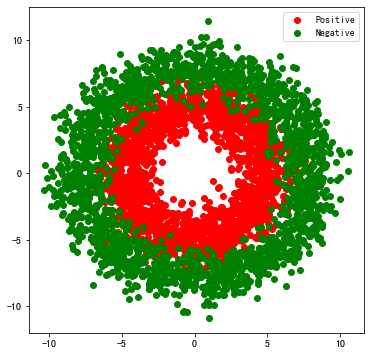

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['Positive', 'Negative'])
plt.show()

In [13]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

In [14]:
batch_size = 8
features, labels = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[ 5.0839, -0.7319],
        [-7.2148, -5.9569],
        [-4.8502,  2.6551],
        [ 2.1679,  8.6294],
        [ 3.9852,  7.8809],
        [ 4.9529, -6.0069],
        [ 6.5453, -4.8775],
        [-4.9698, -1.3694]])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])


### 定义模型

In [15]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.zeros(1, 4))
        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.zeros(1, 8))
        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.zeros(1, 1))
        
    def forward(self,x):
        x = torch.relu(x @ self.w1 + self.b1) # (2000, 2) * (2, 4) + (1, 4) = (2000, 4)
        x = torch.relu(x @ self.w2 + self.b2) # (2000, 4) * (4, 8) + (1, 8) = (2000, 8)
        y = torch.sigmoid(x @ self.w3 + self.b3) # (2000, 8) * (8, 1) + (1, 1) = (2000, 1)
        return y
    
    def loss_func(self, y_pred, y_true):
        eps = 1e-7
        # torch.clamp() 截取小于eps的值为eps, 截取大于1.0-eps的值为1.0-eps
        y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
        bce = -y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        return torch.mean(bce)
    
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(
            y_pred > 0.5,
            torch.ones_like(y_pred, dtype=torch.float32),
            torch.zeros_like(y_pred, dtype=torch.float32)
        )
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc

In [16]:
model = DNNModel()

In [17]:
batch_size = 10
features, labels = next(data_iter(X, Y, batch_size))

predictions = model(features)
loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print('init loss:   ', loss.item())
print('init metric: ', metric.item())

init loss:    6.135199546813965
init metric:  0.5


In [18]:
len(list(model.parameters()))

6

### 训练模型

In [19]:
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降法更新参数
    for param in model.parameters():
        param.data = (param.data - 0.01 * param.grad.data)
        
    # 梯度清零
    model.zero_grad()
    return loss.item(), metric.item()

In [20]:
def train_model(model, epochs):
    for epoch in range(1, 1 + epochs):
        loss_list, metric_list = [], []
        for features, labels in data_iter(X, Y, 20):
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch % 100 == 0:
            printbar()
            print('epoch = {}, loss = {}, metric = {}'.format(epoch, loss, metric))

In [21]:
train_model(model, epochs=1000)


================================================================================2021-06-18 15:28:18
epoch = 100, loss = 0.21839216150343418, metric = 0.9137499949336052

================================================================================2021-06-18 15:28:28
epoch = 200, loss = 0.1964371398743242, metric = 0.9207499924302102

================================================================================2021-06-18 15:28:38
epoch = 300, loss = 0.1938448641076684, metric = 0.9212499925494194

================================================================================2021-06-18 15:28:48
epoch = 400, loss = 0.188513079630211, metric = 0.9194999942183495

================================================================================2021-06-18 15:28:57
epoch = 500, loss = 0.18389269660227, metric = 0.926999993622303

================================================================================2021-06-18 15:29:07
epoch = 600, loss = 0.17640169274527578, metric = 0.92974

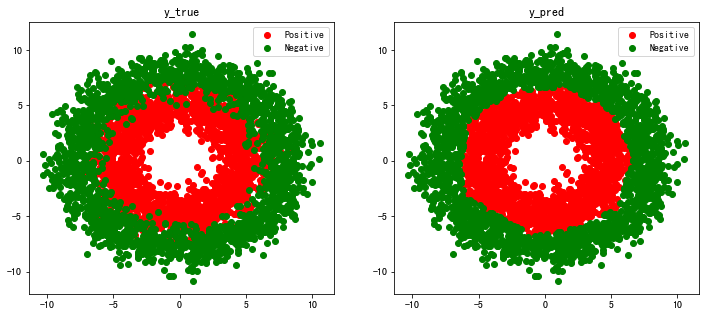

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c='r')
ax1.scatter(Xn[:, 0], Xn[:, 1], c='g')
ax1.legend(['Positive', 'Negative'])
ax1.set_title('y_true')

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c='r')
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c='g')
ax2.legend(['Positive', 'Negative'])
ax2.set_title('y_pred')
plt.show()